Import the libraries

In [1]:
import nltk
"""nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')"""

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\simon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\simon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\simon\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\simon\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.


True

In [2]:
## Data Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.base import clone
%matplotlib inline

# Data Preprocessing and Feature Engineering
import re
import string
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords as sw, stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import TruncatedSVD

#Model Selection and Validation
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [4]:
def save_results(path, model_name, params, accuracy_max):
    with open(path, "w", encoding='utf8') as f:
        f.write(f"{model_name}:\n")
        f.write(f"BEST PARAMS: {params}\n")
        f.write(f"BEST ACCURACY: {accuracy_max}")
        
#&&
DEVELOPMENT = "dataset/development.jsonl"
EVALUATION = "dataset/evaluation.jsonl"
data_dev = pd.read_json(DEVELOPMENT, lines=True)
data_ev = pd.read_json(EVALUATION, lines=True)

Data Exploration


In [5]:
X_dev_text = data_dev.loc[:, "full_text"]
y_dev_text = data_dev.loc[:, "class"]
X_ev_text = data_ev.loc[:, "full_text"]

print(f"Training dataset size: {len(X_dev_text)}\n")
print(f"Evaluation dataset size: {len(X_ev_text)}\n")

Training dataset size: 80000

Evaluation dataset size: 20000



Positive dataset size: 39931

Negative dataset size: 40069



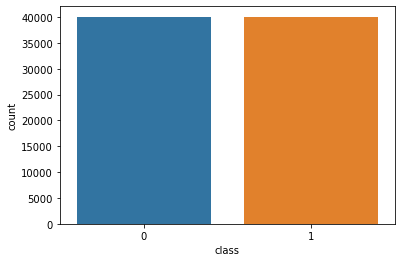

In [6]:
X_dev_text_pos = data_dev.loc[data_dev.loc[:,"class"]==1,"full_text"]
X_dev_text_neg = data_dev.loc[data_dev.loc[:,"class"]==0,"full_text"]

print(f"Positive dataset size: {len(X_dev_text_pos)}\n")
print(f"Negative dataset size: {len(X_dev_text_neg)}\n")

sns.countplot(x = 'class',data = data_dev)

In [7]:
rt = sum(data_dev.loc[:,"retweeted"]==True)
ft = sum(data_dev.loc[:,"favorited"]==True)
print(f"Retweets = {rt} and Favorited = {ft}")

Retweets = 0 and Favorited = 0


In [8]:
print(X_dev_text_neg.shape[0]+X_dev_text_pos.shape[0])
print(X_dev_text.shape[0])

80000
80000


In [14]:
#pip install demoji

In [9]:
import demoji
import re
demoji.download_codes()
example = None
emoji_dict = {}
hashtag_dict= {}

for text in X_dev_text_pos:

    text_list=text.split()
    for word in text_list:
      if word.startswith("#"):
        if word not in hashtag_dict:
          hashtag_dict[word] = [1, 0]
        else:
          hashtag_dict[word][0] += 1

    current_emojis = demoji.findall(text)
    for emoji, desc in current_emojis.items():
        if emoji not in emoji_dict:
            emoji_dict[emoji] = [desc, 1, 0]
        else:
            emoji_dict[emoji][1] += 1
            
for text in X_dev_text_neg:
    text_list=text.split()
    for word in text_list:
      if word.startswith("#"):
        if word not in hashtag_dict:
          hashtag_dict[word] = [0,1]
        else:
          hashtag_dict[word][1] += 1

    current_emojis = demoji.findall(text)
    for emoji, desc in current_emojis.items():
        if emoji not in emoji_dict:
            emoji_dict[emoji] = [desc, 0, 1]
        else:
            emoji_dict[emoji][2] += 1

... OK (Got response in 1.79 seconds)
Writing emoji data to C:\Users\simon\.demoji\codes.json ...
... OK


In [10]:
total = sorted(hashtag_dict.items(), key=lambda x: sum(x[1][1:]),reverse=True)

with open("total_hashtags.txt", "w", encoding='utf8') as f:
    for e in total:
        f.write(f"{e}\n")    


In [11]:
total = sorted(emoji_dict.items(), key=lambda x: sum(x[1][1:]),reverse=True)

with open("total_emojis.txt", "w", encoding='utf8') as f:
    for e in total:
        f.write(f"{e}\n")

In [12]:
sentiment_emojis = {}

for emoji, desc in emoji_dict.items():
    pos_perc = emoji_dict[emoji][1]/sum(emoji_dict[emoji][1:])
    sentiment_emojis[emoji] = pos_perc
    

Stopwords

In [48]:
long_stopwords=[]

STOPWORDS = "stopwords_long.txt"
with open(STOPWORDS, "r") as file:
    for line in file.readlines():
        long_stopwords.append(line[:-1])

stopwords=sw.words('english') + ["'d", "'ll", "'re", "'s", "'ve", 'could','doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would']
print(len(stopwords))
print(len(long_stopwords))

stopwords.extend(long_stopwords)

new_stopwords=list(set(stopwords))

print(len(new_stopwords))

195
665
713


Data Preprocessing

In [47]:
def preprocess_word(word):
    
    # Remove punctuation
    word = word.strip(string.punctuation)
    
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    
    word = re.sub(r'(.)\1+', r'\1\1', word)
    
    # Remove - & '
    word = re.sub(r'(-|\')', '', word)
    
    return word


def is_valid_word(word):
    en_stopwords = sw.words('english') + ["'d", "'ll", "'re", "'s", "'ve", 'could','doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would']
    # Check if word begins with an alphabet is not a char or a stopword
    return re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) \
           and 3 < len(word) < 16 and word not in stopwords is not None


def handle_emojis(tweet,th1,th2):
    emojis = demoji.findall(tweet)
    
    for emoji in emojis.keys(): 
        
        if emoji not in sentiment_emojis:
            continue
        perc= sentiment_emojis[emoji]
        
        if perc > th2:
            tweet = tweet.replace(emoji, 'EM_POS')  #'EM_VERY_POS')
        elif perc > th1:
            tweet = tweet.replace(emoji, 'EM_POS')
        elif perc < (1-th2):
            tweet = tweet.replace(emoji, 'EM_NEG')  #'EM_VERY_NEG')
        elif perc < (1-th1):
            tweet = tweet.replace(emoji, 'EM_NEG')
        else:
            tweet = tweet.replace(emoji, '')    

    return tweet


def preprocess_tweet (tweet,th1,th2):
    
    # Convert to lower case
    tweet = tweet.lower()
    
    # Remove URLs
    tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', '', tweet)
    
    # Remove @handle
    tweet = re.sub(r'@[\S]+', '', tweet)
    
    # Replaces #hashtag with hashtag
    tweet = re.sub(r'#(\S+)', r' \1 ', tweet)
    
    # Remove RT (retweet)
    tweet = re.sub(r'\brt\b', '', tweet)
    
    # Replace 2+ dots with space
    tweet = re.sub(r'\.{2,}', ' ', tweet)
    
    # Strip space, " and ' from tweet
    tweet = tweet.strip(' "\'')
    
    # Replace emojis with either EMO_POS or EMO_NEG
    tweet = handle_emojis(tweet,th1,th2)
    
    # Replace multiple spaces with a single space
    tweet = re.sub(r'\s+', ' ', tweet)
    
    return tweet

class TweetTokenizer(object):
    
    def __init__(self,th1=0.6,th2=0.85):
        self.lemmatizer = WordNetLemmatizer()
        self.th1 = th1
        self.th2 =th2
        
    def __call__(self, tweet):
        
        lemmas = []
        tweet = preprocess_tweet (tweet,self.th1,self.th2)
        
        for t in word_tokenize(tweet):
            
            t = t.strip()
            
            t = preprocess_word(t)
            
            if is_valid_word(t):
             lemma = self.lemmatizer.lemmatize(t)
             lemmas.append(lemma)
                
        return lemmas

In [64]:
"""vectorizer = TfidfVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True,
							  preprocessor=None, tokenizer=TweetTokenizer(th1=0.65,th2=0.85), stop_words=None, ngram_range=(1,2),
							  max_df=0.5, min_df=1, max_features=None)"""

"vectorizer = TfidfVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True,\n\t\t\t\t\t\t\t  preprocessor=None, tokenizer=TweetTokenizer(th1=0.65,th2=0.85), stop_words=None, ngram_range=(1,2),\n\t\t\t\t\t\t\t  max_df=0.5, min_df=1, max_features=None)"

In [16]:
"""vectorizer = CountVectorizer(input='content', encoding='utf-8', tokenizer=TweetTokenizer(th1=0.65,th2=0.85), 
                             stop_words=None, ngram_range=(1,2), max_df=0.5, min_df=1)"""

In [ ]:
vectorizer = TfidfVectorizer(input='content', encoding='utf-8', tokenizer=TweetTokenizer(th1=0.65,th2=0.85), 
                             stop_words=None, ngram_range=(1,2), max_df=0.5, min_df=1)

In [ ]:
vectorizer.fit(X_dev_text)
X_train_tfidf = vectorizer.transform(X_dev_text)

In [67]:
vocabulary = vectorizer.vocabulary_ 
words_left_out = vectorizer.stop_words_

In [68]:
with open("vectorizer.txt", "w", encoding='utf8') as f:
    for e in vocabulary:
        f.write(f"{e}\n")   

In [69]:
with open("words_left_out.txt", "w", encoding='utf8') as f:
    for e in words_left_out:
        f.write(f"{e}\n")

In [70]:
"""X_train, X_test, y_train, y_test = train_test_split(X_dev_text, y_dev_text, shuffle=True, test_size=0.25)

params_model = {'C': [1, 10, 100]}
#params_model = {'C': [1, 5, 10]}
models = [LogisticRegression(n_jobs=8, **config) for config in ParameterGrid(params_model)]

#models = [SVC(kernel="linear", **config) for config in ParameterGrid(params_model)]

pipelines = [Pipeline([
    ('tfidf', vectorizers[0]),
    ('classifier', model),
]) for model in models]"""

'X_train, X_test, y_train, y_test = train_test_split(X_dev_text, y_dev_text, shuffle=True, test_size=0.25)\n\nparams_model = {\'C\': [1, 10, 100]}\n#params_model = {\'C\': [1, 5, 10]}\nmodels = [LogisticRegression(n_jobs=8, **config) for config in ParameterGrid(params_model)]\n\n#models = [SVC(kernel="linear", **config) for config in ParameterGrid(params_model)]\n\npipelines = [Pipeline([\n    (\'tfidf\', vectorizers[0]),\n    (\'classifier\', model),\n]) for model in models]'

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_dev_text, y_dev_text, shuffle=True, test_size=0.25, stratify=y_dev_text)
model = SVC(kernel="rbf", C=10)
tmp_pipe = Pipeline([
    ('count', vectorizer),
    ('classifier', model)
])
tmp_pipe.fit(X_train, y_train)
print("TRAIN OVER")

TRAIN OVER


In [28]:
y_preds = tmp_pipe.predict(X_test)
accuracy_score(y_test, y_preds)

0.924

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X_dev_text, y_dev_text, shuffle=True, test_size=0.25)

model = SVC(kernel="rbf", C=10)

pipelines = Pipeline([
    ('count', vectorizer),
    ('tfidf', TfidfTransformer()),
    ('classifier', model)])

In [96]:
labels_predicted = []
for pipe in pipelines:
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    labels_predicted.append(y_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


AttributeError: ignored

In [ ]:
total_config = []
for conf_vec in ParameterGrid(params_vect):
    for conf_mod in ParameterGrid(params_model):
        conf_mod.update(conf_vec)
        total_config.append(conf_mod)


In [ ]:
accuracies = [accuracy_score(y_test, y_pred) for y_pred in labels_predicted]
best_ind = np.argmax(accuracies)
best_pipeline = pipelines[best_ind]
print(classification_report(y_test, labels_predicted[best_ind]))
print(f"Total Accuracy score: {np.max(accuracies)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, labels_predicted[best_ind])}")
print(f"SVM best params: {list(total_config[best_ind].items())}")

In [ ]:
MODEL_NAME = "Logistic-Cnan"
PATH = f"results/{MODEL_NAME}-emoji-preprocess.txt"
save_results(PATH, MODEL_NAME, list(total_config[best_ind].items()), np.max(accuracies))


In [ ]:
best_pipeline.fit(X_dev_text, y_dev_text)
y_preds = best_pipeline.predict(X_ev_text)

In [ ]:
with open("submission3.csv", "w", encoding="utf8") as f:
    f.write("Id,Predicted\n")
    for i,y in enumerate(y_preds):
        f.write(f"{i},{y}\n")

In [ ]:

'''
for c in data.columns:
    mask = data.loc[:, c].isnull()
    boh[c] = data.loc[mask].shape[0]

plt.figure(figsize=(10,7))
ax = sns.barplot(list(boh.keys()), list(boh.values()))
ax.set_xticklabels(list(boh.keys()), rotation=40, ha="right")
plt.show()
# Dropping useless columns
cleared_dataset = data_dev.drop(columns =['id','in_reply_to_status_id','in_reply_to_user_id',
                                      'created_at', 'truncated', 'retweeted', 'lang', 
                                      'metadata', 'favorited', 'source', 'withheld_in_countries',
                                      'quoted_status_id', 'in_reply_to_screen_name', 'contributors'])
'''
